In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
Board_Rows = 3
Board_Cols = 3
results1 = np.array([])
results2 = np.array([])

In [3]:
class State:

    def __init__(self, p1, p2):
        self.board = np.zeros((Board_Rows, Board_Cols))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None 
        self.playerSymbol = 1 #makes player 1 play first.

    def getHash(self):
        self.boardHash = str(self.board.reshape(Board_Cols*Board_Rows))
        return self.boardHash

    def winner(self):
        for i in range(Board_Rows): #rows
            if sum(self.board[i,:]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i,:]) == -3:
                self.isEnd = True
                return -1
        for i in range(Board_Cols): #cols
            if sum(self.board[:,i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:,i]) == -3:
                self.isEnd = True
                return -1
        #diagonals 
        if np.trace(self.board) == 3 or np.sum(np.fliplr(self.board).diagonal()) == 3:
            self.isEnd = True
            return 1
        if np.trace(self.board) == -3 or np.sum(np.fliplr(self.board).diagonal()) == -3:
            self.isEnd = True
            return -1
        #cheching for the case of a tie or if the game can be continued
        if len(self.available_positions()) == 0:
            self.isEnd = True
            return 0
        else:
            self.isEnd = False
            return None

    def available_positions(self):
        positions = []
        for i in range(Board_Rows):
            for j in range(Board_Cols):
                if self.board[i,j] == 0:
                    positions.append((i,j))
        return positions

    def updateState(self,position):
        self.board[position] = self.playerSymbol
        if self.playerSymbol == 1: #switching player
            self.playerSymbol =-1
        else:
            self.playerSymbol = 1

    def giveReward(self): #only after game ends
        result = self.winner()
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(-1)
        elif result == -1:
            self.p1.feedReward(-1)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.1)

    def reset(self): #reset the board
        self.board = np.zeros((Board_Rows, Board_Cols))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1

    def play(self,rounds=100):
        for i in range(rounds):
            if i%1000 == 0:
                print("Rounds {}".format(i))
            while not self.isEnd:
                positions = self.available_positions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                #take action and update the board state
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                
                #check if the match is done
                win = self.winner()
                if win is not None:
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break
                    
                else: #turn of another player
                    positions = self.available_positions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)

                    win = self.winner()
                    if win is not None:
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break

    def playWithHuman(self):
        while not self.isEnd:
            positions = self.available_positions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            # take action and upate board state
            self.updateState(p1_action)
            self.showBoard()
            # check board status if it is end
            win = self.winner()
            if win is not None:
                if win == 1:
                    print(self.p1.name, "wins!")
                else:
                    print("tie!")
                self.reset()
                break

            else:
                # Player 2
                positions = self.available_positions()
                p2_action = self.p2.chooseAction(positions)
                self.updateState(p2_action)
                self.showBoard()
                win = self.winner()
                print(win)
                if win is not None:
                    if win == -1:
                        print(self.p2.name, "wins!")
                    else:
                        print("tie!")
                    self.reset()
                    break

    def showBoard(self):
        for i in range(Board_Rows):
            print('-------------')
            ch = '| '
            for j in range(Board_Cols):
                if self.board[i,j] == 1:
                    token = 'x'
                if self.board[i,j] == -1:
                    token = 'o'
                if self.board[i,j] == 0:
                    token = ' '
                ch += token + ' | '
            print(ch)
        print('-------------')                

In [4]:
class Player:
    
    def __init__(self, name, exp_rate=0.3):
        self.name = name
        self.states = []
        self.lr = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}
        self.results1 = np.array([])

    def getHash(self,board):
        BoardHash = str(board.reshape(Board_Cols*Board_Rows))
        return BoardHash

    def chooseAction(self, positions, current_board, symbol):
        if np.random.uniform(0,1) <= self.exp_rate: #take random action
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                # takes the next action accordingly
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                if value >= value_max:
                    value_max = value
                    action = p
        return action

    def addState(self,state): #append the state
        self.states.append(state)

    def feedReward(self, reward):
        if self.name == "computer":
            global results1
            results1 = np.append(results1, reward)
        if self.name == "p3":
            global results2
            results2 = np.append(results2, reward)
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr*(self.decay_gamma*reward - self.states_value[st])
            reward = self.states_value[st]

    def reset(self):
        self.states = []

    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()

    def loadPolicy(self, file):
        fr = open(file,'rb')
        self.states_value = pickle.load(fr)
        fr.close()

In [5]:
# train the model
p1 = Player("p1")
p2 = Player("p2")

st = State(p1,p2)
print("traing....")
st.play(50000)

traing....
Rounds 0
Rounds 1000
Rounds 2000
Rounds 3000
Rounds 4000
Rounds 5000
Rounds 6000
Rounds 7000
Rounds 8000
Rounds 9000
Rounds 10000
Rounds 11000
Rounds 12000
Rounds 13000
Rounds 14000
Rounds 15000
Rounds 16000
Rounds 17000
Rounds 18000
Rounds 19000
Rounds 20000
Rounds 21000
Rounds 22000
Rounds 23000
Rounds 24000
Rounds 25000
Rounds 26000
Rounds 27000
Rounds 28000
Rounds 29000
Rounds 30000
Rounds 31000
Rounds 32000
Rounds 33000
Rounds 34000
Rounds 35000
Rounds 36000
Rounds 37000
Rounds 38000
Rounds 39000
Rounds 40000
Rounds 41000
Rounds 42000
Rounds 43000
Rounds 44000
Rounds 45000
Rounds 46000
Rounds 47000
Rounds 48000
Rounds 49000


In [6]:
p1.savePolicy()
p2.savePolicy()

In [7]:
p1 = Player("p3", exp_rate = 0.1)
p1.loadPolicy("policy_p1")

p2 = Player("p2", exp_rate = 0.1)
p2.loadPolicy("policy_p2")

st = State(p1,p2)
st.play(50000)

Rounds 0
Rounds 1000
Rounds 2000
Rounds 3000
Rounds 4000
Rounds 5000
Rounds 6000
Rounds 7000
Rounds 8000
Rounds 9000
Rounds 10000
Rounds 11000
Rounds 12000
Rounds 13000
Rounds 14000
Rounds 15000
Rounds 16000
Rounds 17000
Rounds 18000
Rounds 19000
Rounds 20000
Rounds 21000
Rounds 22000
Rounds 23000
Rounds 24000
Rounds 25000
Rounds 26000
Rounds 27000
Rounds 28000
Rounds 29000
Rounds 30000
Rounds 31000
Rounds 32000
Rounds 33000
Rounds 34000
Rounds 35000
Rounds 36000
Rounds 37000
Rounds 38000
Rounds 39000
Rounds 40000
Rounds 41000
Rounds 42000
Rounds 43000
Rounds 44000
Rounds 45000
Rounds 46000
Rounds 47000
Rounds 48000
Rounds 49000


In [8]:
p1 = Player("computer", exp_rate = 0.0)
p1.loadPolicy("policy_p1")

p2 = Player("random", exp_rate = 1.0)

st = State(p1,p2)
st.play(50000)

Rounds 0
Rounds 1000
Rounds 2000
Rounds 3000
Rounds 4000
Rounds 5000
Rounds 6000
Rounds 7000
Rounds 8000
Rounds 9000
Rounds 10000
Rounds 11000
Rounds 12000
Rounds 13000
Rounds 14000
Rounds 15000
Rounds 16000
Rounds 17000
Rounds 18000
Rounds 19000
Rounds 20000
Rounds 21000
Rounds 22000
Rounds 23000
Rounds 24000
Rounds 25000
Rounds 26000
Rounds 27000
Rounds 28000
Rounds 29000
Rounds 30000
Rounds 31000
Rounds 32000
Rounds 33000
Rounds 34000
Rounds 35000
Rounds 36000
Rounds 37000
Rounds 38000
Rounds 39000
Rounds 40000
Rounds 41000
Rounds 42000
Rounds 43000
Rounds 44000
Rounds 45000
Rounds 46000
Rounds 47000
Rounds 48000
Rounds 49000


The characteristics of the system is: 
 win percentage is 99.03 
 tie percentage is 0.97 
 lose percentage is 0.0


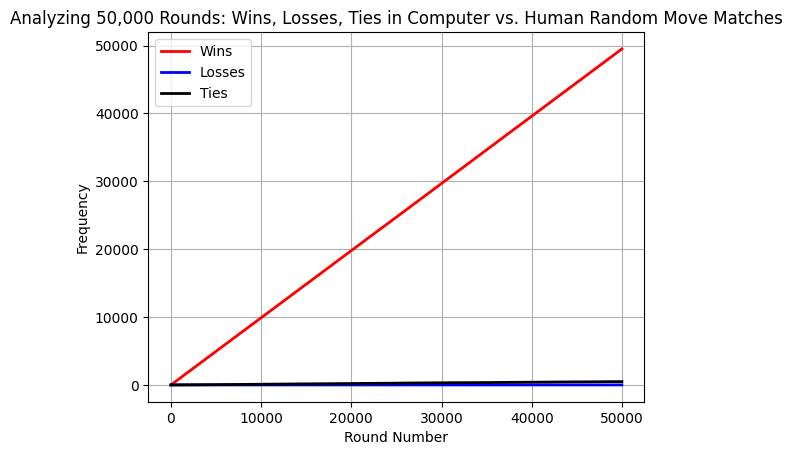

In [14]:
wins = np.zeros(50000)
losses = np.zeros(50000)
ties = np.zeros(50000)

# Calculate the frequency of wins, losses, and ties
for i in range(50000):
    wins[i] = np.sum(results1[:i + 1] == 1)
    losses[i] = np.sum(results1[:i + 1] == -1)
    ties[i] = np.sum(results1[:i + 1] == 0.1)

# Calculate the percentages
round_numbers = np.arange(1, 50001)
win_percentage = wins / round_numbers * 100
tie_percentage = ties / round_numbers * 100
lose_percentage = losses / round_numbers * 100

# Plotting
plt.figure()

plt.plot(wins, 'r', label='Wins', linewidth=2)
plt.plot(losses, 'b', label='Losses', linewidth=2)
plt.plot(ties, 'k', label='Ties', linewidth=2)

plt.title('Analyzing 50,000 Rounds: Wins, Losses, Ties in Computer vs. Human Random Move Matches')
plt.xlabel('Round Number')
plt.ylabel('Frequency')

plt.legend()
plt.grid(True)

print('The characteristics of the system is: \n win percentage is {} \n tie percentage is {} \n lose percentage is {}'.format(win_percentage[-1],tie_percentage[-1],lose_percentage[-1]))

The characteristics of the system is: 
 win percentage is 20.596 
 tie percentage is 72.816 
 lose percentage is 6.587999999999999


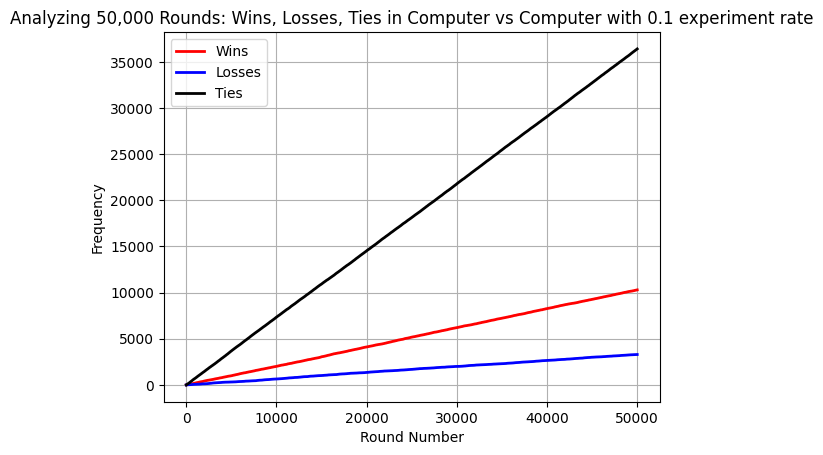

In [15]:
wins = np.zeros(50000)
losses = np.zeros(50000)
ties = np.zeros(50000)

# Calculate the frequency of wins, losses, and ties
for i in range(50000):
    wins[i] = np.sum(results2[:i + 1] == 1)
    losses[i] = np.sum(results2[:i + 1] == -1)
    ties[i] = np.sum(results2[:i + 1] == 0.1)

# Calculate the percentages
round_numbers = np.arange(1, 50001)
win_percentage = wins / round_numbers * 100
tie_percentage = ties / round_numbers * 100 
lose_percentage = losses / round_numbers * 100

# Plotting
plt.figure()

plt.plot(wins, 'r', label='Wins', linewidth=2)
plt.plot(losses, 'b', label='Losses', linewidth=2)
plt.plot(ties, 'k', label='Ties', linewidth=2)

plt.title('Analyzing 50,000 Rounds: Wins, Losses, Ties in Computer vs Computer with 0.1 experiment rate')
plt.xlabel('Round Number')
plt.ylabel('Frequency')

plt.legend()
plt.grid(True)

print('The characteristics of the system is: \n win percentage is {} \n tie percentage is {} \n lose percentage is {}'.format(win_percentage[-1],tie_percentage[-1],lose_percentage[-1]))